Generating distorted characters in a variety of fonts and teaching a network to recognize them.
This application will take background patches or noise and generate random text on top of them with tuples of three letters.  The three letters let us predict 'first', 'middle', and 'last' letters so that we can chain together full words.  Transforms include affine and perspective distortions.

In [469]:
%matplotlib inline

import os
import sys
import json
import random
import pickle
import string
from glob import glob

import numpy
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Activation, LeakyReLU
import matplotlib
import matplotlib.pyplot as plt

## Data Generation

In [568]:
# Constants
STRING_LENGTH = 1
TEXT_SIZE = (32, 32)
IMAGE_SIZE = TEXT_SIZE # For now.  We'll want to crop out a section of an image.
FONTS_DIR = "/usr/share/fonts/truetype/"
FONT_CHOICES = glob(os.path.join(FONTS_DIR, "*", "*.ttf"))

In [569]:
# Crop from an image.
#base = Image.open('Pillow/Tests/images/hopper.png').convert('RGBA')
base = Image.new('RGBA', IMAGE_SIZE,(0, 0, 0, 255))

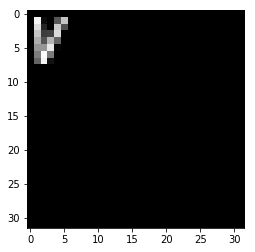

V


In [965]:
# Make a blank image for the text, initialized to transparent text color
printable_chars = [c for c in string.printable if c.isalnum()]
def new_text_image(opacity=255, color=(255, 255, 255)):
    txt_image = Image.new('RGBA', TEXT_SIZE, (255,255,255,0))

    # Randomly select a font and a size.
    font_size = random.randint(8, 24)
    fnt = ImageFont.truetype(random.choice(FONT_CHOICES), font_size)

    # Get a drawing context.
    d = ImageDraw.Draw(txt_image)

    # Generate three random characters.
    target_string = "".join([random.choice(printable_chars) for _ in range(STRING_LENGTH)])

    # Full opacity, 1/nth of the way down the image, making it roughly centered.
    x_start = 0 #random.randint(0, TEXT_SIZE[0]//2)
    y_start = 0 #random.randint(0, TEXT_SIZE[1]//3)
    d.text((x_start, y_start), target_string, font=fnt, fill=(color[0], color[1], color[2], opacity)) # 255 = full opacity.
    
    return txt_image, target_string

# DEBUG SAMPLE COMPOSITE:
txt_image, target_str = new_text_image()
out_undistorted = Image.alpha_composite(base, txt_image)
#out.show()
plt.imshow(out_undistorted)
plt.show()
print(target_str)

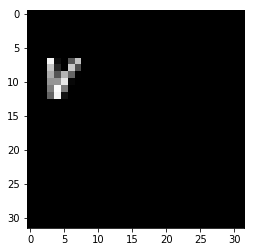

In [1038]:
# Make a random transform and distort the text.
def distort_text_image(txt):
    # Upper left, lower left, lower right, upper_right.
    left_min = -10
    left_max = 0
    right_min = TEXT_SIZE[0]-2
    right_max = TEXT_SIZE[0]
    top_min = -10
    top_max = 0
    bottom_min = TEXT_SIZE[1]-2
    bottom_max = TEXT_SIZE[1]
    # Upper left
    x0 = random.randint(left_min, left_max)
    y0 = random.randint(top_min, top_max)
    # Lower left
    x1 = random.randint(left_min, left_max)
    y1 = random.randint(bottom_min, bottom_max)
    # Lower right
    x2 = random.randint(right_min, right_max)
    y2 = random.randint(bottom_min, bottom_max)
    # Upper right
    x3 = random.randint(right_min, right_max)
    y3 = random.randint(top_min, top_max)
    transform = ImageTransform.QuadTransform((x0, y0, x1, y1, x2, y2, x3, y3))
    txt_distorted = transform.transform(TEXT_SIZE, txt)
    return txt_distorted

# DEBUG: Composite
txt_distorted = distort_text_image(txt_image)
out_distorted = Image.alpha_composite(base, txt_distorted)
plt.imshow(out_distorted)
plt.show()

## Model Creation

In [1064]:
model = Sequential()
# Standard fare 3x3 convs stacked.  No activation between them.
model.add(Conv2D(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), filters=64, kernel_size=(3, 3), strides=(1,1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1)))
model.add(LeakyReLU())

# Using 2,2 stride on Conv2D instead of max pool seems to perform better.
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1)))
model.add(LeakyReLU())

# One more pass with stacked convolutions.
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2)))
model.add(LeakyReLU())

# Begin the flat portion.
model.add(Flatten())

model.add(Dense(256))
model.add(LeakyReLU())
#model.add(Dropout(rate=0.5))

# Final layer.
model.add(Dense(STRING_LENGTH*(ord('~')+1))) # 3 rows, 128 columns.  Maybe use output_shape?
model.add(LeakyReLU())
model.add(Reshape((STRING_LENGTH, 1+ord('~'))))
model.add(Activation('softmax'))

#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) # NOT binary_xent
model.compile(optimizer='rmsprop', loss='kullback_leibler_divergence', metrics=['accuracy'])

print(model.count_params())
print(model.summary())

3865023
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_300 (Conv2D)          (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_178 (LeakyReLU)  (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 26, 26, 128)       73856     
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 24, 24, 128)       147584    
_________________________________________________________________
leaky_re_lu_179 (LeakyReLU)  (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 22, 22, 128)       147584    
__

## Train

In [1040]:
def generator(base_image_selector, batch_size):
    image_files = glob(base_image_selector)
    batch = numpy.zeros((batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=numpy.uint8)
    labels = numpy.zeros((batch_size, STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
    while True:
        # Load an image.
        base_filename = random.choice(image_files)
        img = Image.open(base_filename).convert('RGBA')
        #img = Image.new('RGBA', IMAGE_SIZE) # DEBUG
        for i in range(batch_size):
            # Cut out a section of it.
            x = random.randint(0, img.size[0]-IMAGE_SIZE[0])
            y = random.randint(0, img.size[1]-IMAGE_SIZE[1])
            right = x+IMAGE_SIZE[0]
            bottom = y+IMAGE_SIZE[1]
            region = img.crop((x, y, right, bottom))
            # Select the average color of this region so we can pick a random color that avoids it.
            average_color = [0, 0, 0]
            num_pixels = IMAGE_SIZE[0]*IMAGE_SIZE[1]
            for y in range(0, IMAGE_SIZE[1]):
                for x in range(0, IMAGE_SIZE[0]):
                    pix = region.getpixel((x, y))
                    average_color[0] += pix[0]
                    average_color[1] += pix[1]
                    average_color[2] += pix[2]
            average_color[0] = int(average_color[0]/num_pixels)
            average_color[1] = int(average_color[1]/num_pixels)
            average_color[2] = int(average_color[2]/num_pixels)
            # Select a color that is very high contrast.
            r = random.randint(average_color[0] + 50, average_color[0] + 150)%255 # Wrap around.
            g = random.randint(average_color[1] + 50, average_color[1] + 150)%255 # Wrap around.
            b = random.randint(average_color[2] + 50, average_color[2] + 150)%255 # Wrap around.
            # Produce a random text image and the matching characters.
            text_image, text_string = new_text_image(opacity=random.randint(230, 255), color=(r, g, b))
            # Distort the text image, maybe.
            if random.choice((True, False)):
                text_image = distort_text_image(text_image)
            # Superimpose the text on the image.
            out = Image.alpha_composite(region, text_image)
            example = numpy.asarray(out.convert('RGB'))
            # Convert our text into an array of size 3x128
            label = numpy.zeros(shape=(STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
            for j in range(STRING_LENGTH):
                label[j][ord(text_string[j])] = 1
            # Return our training + label pair
            batch[i,:,:,:] = example[:,:,:]
            labels[i,:,:] = label[:,:]
        yield batch, labels

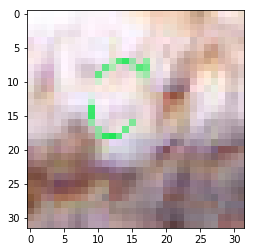

C
(10, 1, 127)


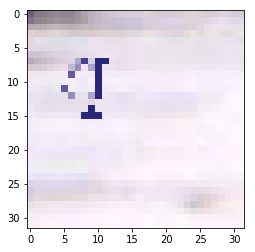

q
(10, 1, 127)


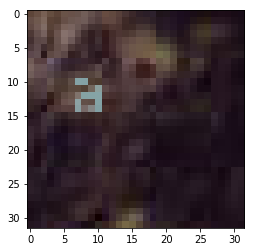

a
(10, 1, 127)


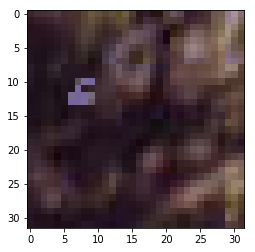

s
(10, 1, 127)


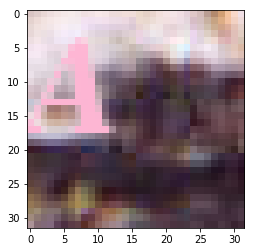

A
(10, 1, 127)


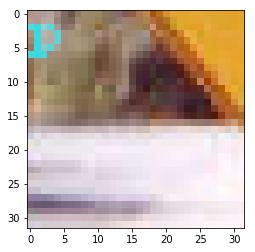

p
(10, 1, 127)


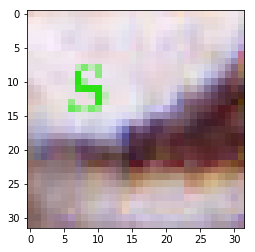

S
(10, 1, 127)


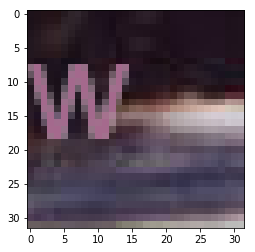

w
(10, 1, 127)


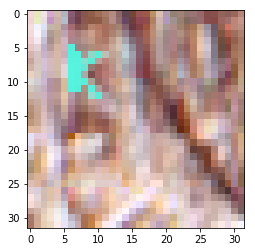

K
(10, 1, 127)


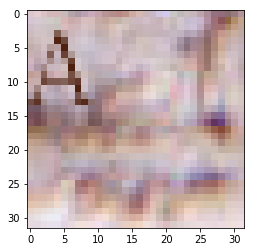

A
(10, 1, 127)


In [1041]:
gen = generator("./train2014/*.jpg", batch_size=10)
x, y = next(gen)
for i in range(0, x.shape[0]):
    plt.imshow(Image.fromarray(x[i,:,:,:]))
    plt.show()
    print(chr(numpy.argmax(y[i][0])))
    print(y.shape)

In [1065]:
for i in range(100):
    print("Training meta-epoch {}".format(i))
    #x, y = next(gen)
    #model.train_on_batch(x/255.0, y)
    model.fit_generator(gen, epochs=10, steps_per_epoch=100) # Yield 1000 batches of 10 items from generator per epoch.
    if i%1 == 0:
        x, y = next(gen)
        prediction = model.predict(x/255.0)
        print("Sample from epoch {}".format(i))
        plt.imshow(Image.fromarray(x[0,:,:,:]))
        plt.show()
        print("Character guesses:")
        c = chr(numpy.argmax(prediction[0,0,:]))
        print("{}".format(c))
        print("Correct answer:")
        c = chr(numpy.argmax(y[0,0,:]))
        print("{}".format(c))
        print("Middle character distribution:")
        print(prediction[0,0,:])
    if i%100 == 0:
        print("Checkpointing.  Saving model.")
        model.save("ocr.h5")

Training meta-epoch 0
Epoch 1/10
100/100 [==============================] - 26s - loss: 15.8301 - acc: 0.0170          

KeyboardInterrupt: 

In [474]:
model.predict(x[:,:,:])

array([[[  7.55412660e-13,   8.58356372e-11,   5.71319251e-13, ...,
           4.52357227e-08,   1.52751272e-05,   4.85312648e-06]],

       [[  6.64002837e-12,   3.50926337e-11,   6.56412164e-12, ...,
           6.85671903e-03,   4.33516763e-02,   6.59151818e-04]],

       [[  5.98294050e-19,   1.69617143e-16,   8.23235892e-19, ...,
           7.52842288e-06,   6.45953289e-04,   1.75290808e-07]],

       ..., 
       [[  3.47043626e-17,   6.23225455e-15,   4.45453072e-17, ...,
           4.14988517e-06,   1.32645015e-04,   9.86693412e-05]],

       [[  2.36452763e-12,   8.72953515e-11,   2.47703984e-12, ...,
           1.18275248e-05,   2.10134676e-04,   2.76585724e-05]],

       [[  1.20801780e-09,   6.78381795e-09,   1.08160925e-09, ...,
           1.38537341e-03,   6.67931465e-03,   3.08042411e-02]]], dtype=float32)